In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from lmfit import Model

from scipy.stats import linregress
from contact_resistance_v2 import idea

sns.set_theme(style = 'ticks', palette = 'Set1') #'Set1', 'Pastel1', 'Dark2'

In [23]:
# MODEL
def r_t(s, r_s, l_t, N, W, L):
    return (r_s * s / (N * W + (N-1) * (2 *s + L))) + (2 * r_s * l_t / (N * W + (N-1) * (2 *s + L)))

#Create model and parameters
gmodel5 = Model(r_t)
param5 = gmodel5.make_params()
param5['r_s'].set(value = 1e10, min = 0)
param5['l_t'].set(value = 1, min = 0)
param5['L'].set(value = 3200e-4, vary = False)
param5['W'].set(value = 5e-4, vary = False)
param5['N'].set(value = 60, vary = False)

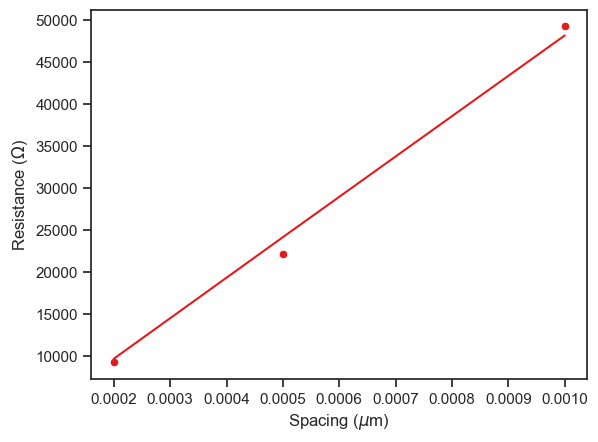

In [41]:
sample = '0G_13'
path = r'C:\Users\lopezb41\OneDrive - imec\Documents\Experiments\Data\Contact Resistance\LSB_07\misc\LCR\0G_13'
path_save = r'C:\Users\lopezb41\OneDrive - imec\Documents\Experiments\Data\Contact Resistance\LSB_07\Results'
files = [os.path.join(path, i) for i in os.listdir(path)]

col_r = ['Spacing ($\mu$m)', 'Resistance ($\Omega$)', 'Column']
col_v = ['Sheet resistance ($\Omega$/sq)', 'Contact resistance ($\Omega$/sq)', 'Conductivity (S/cm)', 'Sample']
r = pd.DataFrame(columns = col_r)
v = pd.DataFrame(columns = col_v)




n=0
for i in files:
    df = pd.read_csv(i)
    slope, intercept, rvalue, pvalue, stderr = linregress(df['Vds'], df['Idc'])
    if i[-5:-4] == '1':
        df['Spacing ($\mu$m)'] = 2e-4
        r.loc[n] = [2e-4, 1/slope, i[-10:-8]]
    elif i[-5:-4] == '2':
        df['Spacing ($\mu$m)'] = 5e-4
        r.loc[n] = [5e-4, 1/slope, i[-10:-8]]
    elif i[-5:-4] == '3':
        df['Spacing ($\mu$m)'] = 10e-4
        r.loc[n] = [10e-4, 1/slope, i[-10:-8]]
    elif i[-5:-4] == '4':
        df['Spacing ($\mu$m)'] = 20e-4
        r.loc[n] = [20e-4, 1/slope, i[-10:-8]]
    n += 1

r = r.sort_values(by = [col_r[0]])





# df = r_aut[r_aut.Column == i]
result = gmodel5.fit(r[col_r[1]], param5, s = r[col_r[0]])
rc2 = gmodel5.eval(result.params, s = 0)
rs = result.values['r_s']
sigma = 1/  (rs * 80 * 1e-7)
r.loc[:,('Fit')] = result.best_fit
r['Sample'] = sample
v.loc[n] = [rs, rc2 / 2, sigma, sample]

# Plot
fig, ax = plt.subplots(dpi = 100)
sns.scatterplot(data = r, x = col_r[0], y = col_r[1])
sns.lineplot(data = r, x = col_r[0], y = 'Fit')

r.to_csv(os.path.join(path_save, sample + '.txt'), sep = ';', index = False)
v.to_csv(os.path.join(path_save, 'val_' + sample + '.txt'), sep = ';', index = False)